#ЧАСТЬ 1 практика

In [156]:
import numpy as np
import sympy as sp
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Для решения 1.1 зададим простые системы координат в каждом шарнире и найдём матрицу преобразования от основания к энд эффектору. ПО большей части мы поворачиваем вокруг текущего x(оси) и движемся вдоль y(оси).

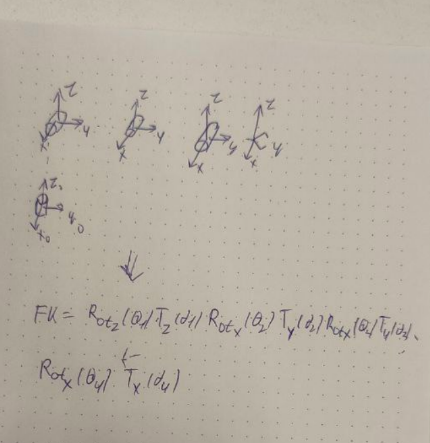

In [157]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T

In [158]:
# robot parameters, links (m)
d1 = 0.5
d2 = 1.0
d3 = 0.3
d4 = 0.2

In [159]:
q_test = np.array([0,0,0,np.pi/2])

## 1.1
тогда код для заданиявыглядит как


In [160]:
def FK(q):
    Matrix = Rz(q[0]) @ Tz(d1) @ Rx(q[1]) @ Ty(d2) @ Rx(q[2]) @ Ty(d3) @ Rx(q[3]) @ Ty(d4)
    x,y,z = Matrix[:3,3]
    phi = np.sum(q)
    return np.array([x, y, z, phi])

In [161]:
q_test = np.array([0,0,0,np.pi/2])
FK(q_test)

array([0.        , 1.3       , 0.7       , 1.57079633])

##1.4
Построение по Денавиту Хартенбергу

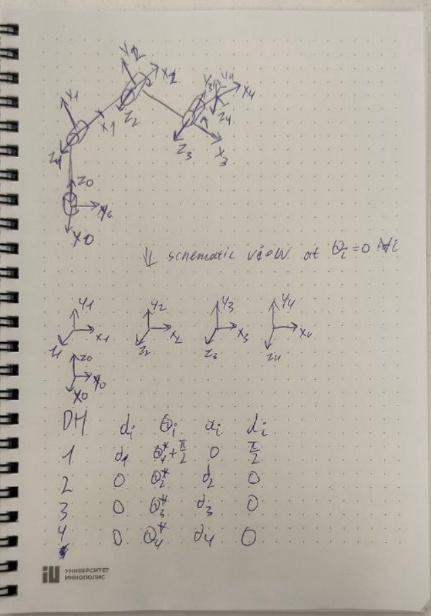

In [162]:
def DH(d, theta, a, alpha):
    A = Rz(theta) @ Tz(d) @ Tx(a) @ Rx(alpha)
    return A

In [163]:
d_p= np.array([d1, 0, 0, 0])
th_p = np.array([np.pi/2, 0, 0, 0])
a_p = np.array([0, d2, d3, d4])
al_p = np.array([np.pi/2, 0, 0, 0])

In [194]:
def FK_DH(q_cor):
    Matrix = np.eye(4)

    for i, q in enumerate(q_cor):
      Matrix = Matrix @ DH(d_p[i], th_p[i]+q, a_p[i], al_p[i])

    x,y,z = Matrix[:3,3]
    phi = np.sum(q_cor)

    return np.array([x, y, z, phi])


##1.5
сравнение прямой кинематики ДХ и обычными матрциами поворота от своих систем

In [191]:
q_test = np.array([np.pi/3,0,np.pi/6,np.pi/2])
FK_DH(q_test)

array([-1.00442286,  0.57990381,  0.82320508,  3.14159265])

In [192]:
FK(q_test)

array([-1.00442286,  0.57990381,  0.82320508,  3.14159265])

In [193]:
FK_DH(q_test)-FK(q_test) # e^-16 is almost 0

array([0.00000000e+00, 2.22044605e-16, 0.00000000e+00, 0.00000000e+00])

##1.2
Решение обратной кинематики.
Я буду использовать систему по параметрам ДХ
Очевидно, что за перемещение в xy плоскости отвечает лишь первый шарнир, поэтому мы можем найти первый угол чисто из atan2(y,x) координат энд эффектора


Зная $\theta_{1}$ мы можем вычесть её из $\phi$  и получить ориентацию энд эффектора. Очевидно, что она будет совподать с ориентацией 4 шарнира, так как в моей конфигурации система энд эффектора повторяет систему 4 шарнира, но на расстоянии. Тогда можно просто посчитать, что на самом деле 4 шарнир это сферическое запястье и мы должны получить его центр, решить проблему для 2 и 3 шарнира, а оставшийся угол мы посчитаем через разность $\phi$ - $\theta_{1}$ -$\theta_{2}$ -$\theta_{3}$


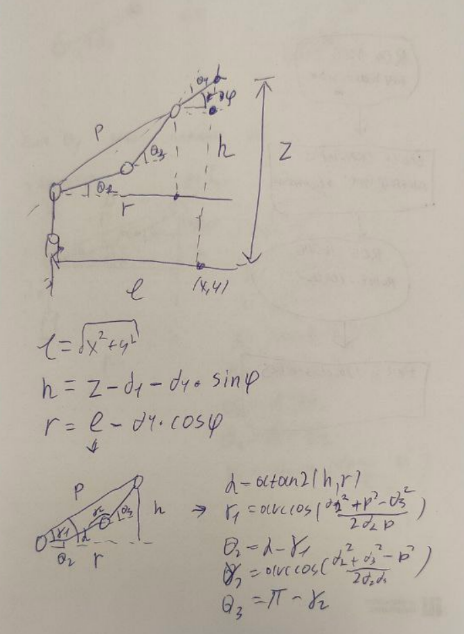

In [168]:
def get_cosine_law_angle(a, b, c):
  # given all sides of a triangle a, b, c
  # calculate angle gamma between sides a and b using cosine law
  cos_gamma = (a*a + b*b - c*c) / (2*a*b)
  if np.abs(cos_gamma) >=1:
      return 0
  sin_gamma = np.sqrt(1 - cos_gamma * cos_gamma)
  gamma = np.arctan2(sin_gamma, cos_gamma)

  return gamma

def first_angles(wrist_center):
    l, z = wrist_center
    r = l
    h = z - d1
    p = np.sqrt(r**2+h**2)
    alpha = np.arctan2(h, r)
    gamma1 = get_cosine_law_angle(d2, p, d3)
    theta2 = alpha - gamma1
    gamma2 = get_cosine_law_angle(d2, d3, p)
    theta3 = np.pi - gamma2
    return theta2, theta3

In [169]:
def get_wrist_center(xyz, phi):
    x, y, z = xyz
    z = z - d4* np.sin(phi)
    l = np.sqrt(x**2+y**2) - d4* np.cos(phi)
    return np.array([l, z])

In [201]:
def IK(pos):
    xyz, phi = pos[:3], pos[3]
    x, y, z = xyz
    q1 = np.arctan2(y, x) -np.pi/2
    phi_plane = phi - q1
    wrist_center = get_wrist_center(xyz, phi_plane)
    q2, q3 = first_angles(wrist_center)
    q4 = phi -q1-q2-q3

    return np.array([q1, q2, q3, q4])

##1.3

проверим что решение обратной кинематики совпадает (или по крайней мере даёт тот же результат)

In [202]:
FK_DH(q_test)

array([-0.41562694,  0.5720614 ,  1.70710678,  2.19911486])

In [206]:
q_test = np.array([np.pi/5, np.pi/4, np.pi/4, -np.pi/3])
print(q_test)
IK(FK_DH(q_test))

[ 0.62831853  0.78539816  0.78539816 -1.04719755]


array([ 0.62831853,  0.78539816,  0.78539816, -1.04719755])

In [207]:
FK_DH(IK(FK_DH(q_test)))

array([-0.51743433,  0.71218726,  1.60710678,  1.15191731])

In [208]:
FK_DH(q_test)

array([-0.51743433,  0.71218726,  1.60710678,  1.15191731])

#ЧАСТЬ 2 ТЕОРИЯ

##2.1


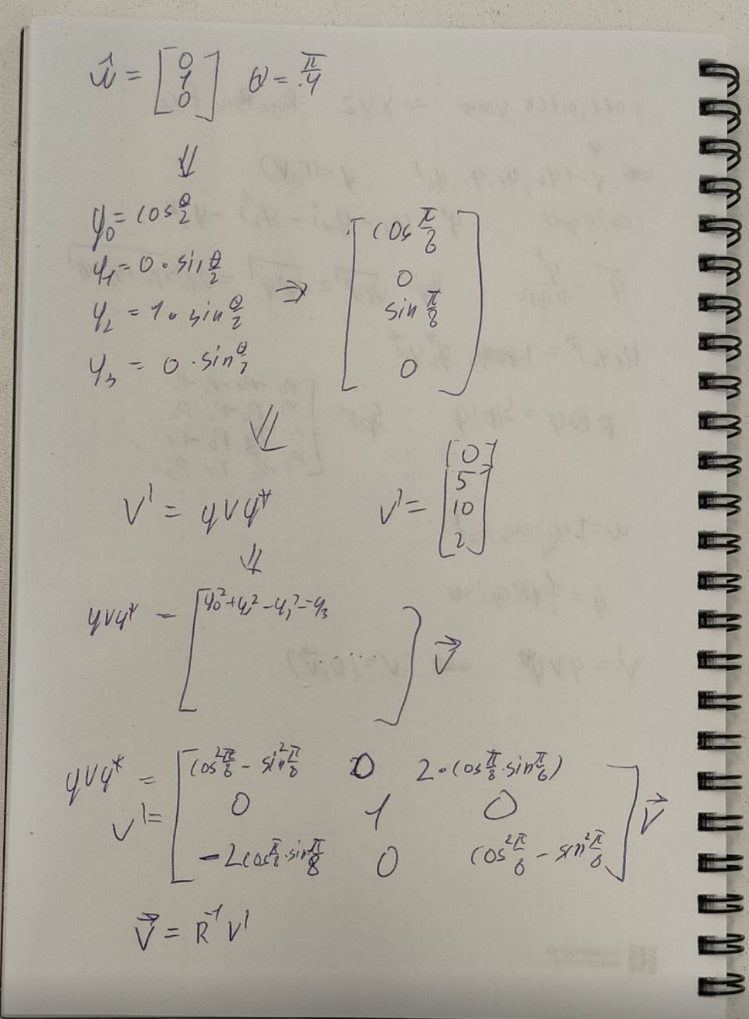

In [155]:
a00 = np.cos(np.pi/8)**2 - np.sin(np.pi/8)**2
a02 = 2*np.cos(np.pi/8)*np.sin(np.pi/8)

Rot_quat = np.array([[a00, 0, a02],
                     [0, 1, 0],
                     [-a02, 0, a00]])

Inverse = np.linalg.inv(Rot_quat)
Initial_vector = Inverse @ np.array([5, 10, 2]).T
Initial_vector

array([ 2.12132034, 10.        ,  4.94974747])

##2.2

Решим задачу написав матрицы поворота на sympy.
При решении задачи важно понимать, что при повороте на фиксированную ось мы домножаем слева, а не справа. по итогу получим выражение


Rx($\tau$) Ry($\theta$) Rz($\beta$) Rx($\alpha$) Rz($\psi$)

In [ ]:
import sympy as sp

In [ ]:
def Rxs(q):
    T = sp.Matrix([[1,         0,          0, 0],
                  [0, sp.cos(q), -sp.sin(q), 0],
                  [0, sp.sin(q),  sp.cos(q), 0],
                  [0,         0,          0, 1]])
    return T


def Rys(q):
    T = sp.Matrix([[ sp.cos(q), 0, sp.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-sp.sin(q), 0, sp.cos(q), 0],
                  [         0, 0,         0, 1]])
    return T


def Rzs(q):
    T = sp.Matrix([[sp.cos(q), -sp.sin(q), 0, 0],
                  [sp.sin(q),  sp.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]])
    return T

In [ ]:
alpha = sp.Symbol(r"\alpha")
beta = sp.Symbol(r"\beta")
theta = sp.Symbol(r"\theta")
psi = sp.Symbol(r"\psi")
tau = sp.Symbol(r"\tau")

In [ ]:
Result_matrix = Rxs(tau) @ Rys(theta) @ Rzs(beta) @ Rxs(alpha) @ Rzs(psi)
Result_matrix

Matrix([
[                                                                                 (sin(\alpha)*sin(\theta) - sin(\beta)*cos(\alpha)*cos(\theta))*sin(\psi) + cos(\beta)*cos(\psi)*cos(\theta),                                                                                  (sin(\alpha)*sin(\theta) - sin(\beta)*cos(\alpha)*cos(\theta))*cos(\psi) - sin(\psi)*cos(\beta)*cos(\theta),                                                sin(\alpha)*sin(\beta)*cos(\theta) + sin(\theta)*cos(\alpha), 0],
[((-sin(\beta)*sin(\tau)*sin(\theta) + cos(\beta)*cos(\tau))*cos(\alpha) - sin(\alpha)*sin(\tau)*cos(\theta))*sin(\psi) + (sin(\beta)*cos(\tau) + sin(\tau)*sin(\theta)*cos(\beta))*cos(\psi), ((-sin(\beta)*sin(\tau)*sin(\theta) + cos(\beta)*cos(\tau))*cos(\alpha) - sin(\alpha)*sin(\tau)*cos(\theta))*cos(\psi) - (sin(\beta)*cos(\tau) + sin(\tau)*sin(\theta)*cos(\beta))*sin(\psi), -(-sin(\beta)*sin(\tau)*sin(\theta) + cos(\beta)*cos(\tau))*sin(\alpha) - sin(\tau)*cos(\alpha)*cos(\theta), 0],
[ (

##2.3

Чтобы реализовать управление с клавиатуру нам нужно написать программу (на питоне или плюсах) для сканирования инпута от пользователя.
Посколько напрямую будет сложно работать с данными клавиатуры лучше считывать их одним нодом, а обрабатывать другим.

Таким образом у нас будет нода считывающая инпут с клавиатуры, которая будет публиковать сообщения нужного вида в топик key_board_scan к примеру, оттуда robot_control считывает данные, обрабатывает, считает и публикует их уже в joint_state топик, которые отвечает за доступ к текущему стейту джоинтов для всего сотального (симуляций, визуализаций и.т.п.)



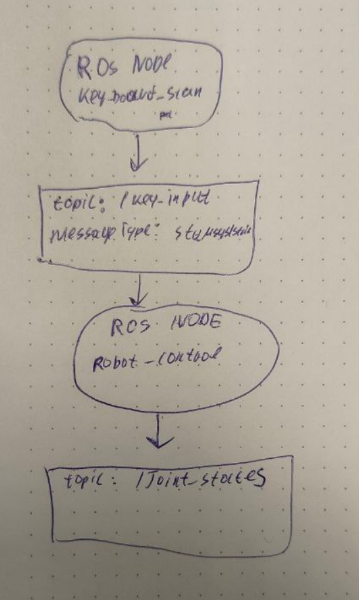